In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laptop-absa/test.tsv
/kaggle/input/laptop-absa/train.tsv
/kaggle/input/laptop-absa/eval.csv
/kaggle/input/laptop-absa/eval.tsv
/kaggle/input/laptop-absa/train.csv
/kaggle/input/laptop-absa/test.csv
/kaggle/input/laptop-absa/data.csv
/kaggle/input/absa-dataset/stanza/Laptops_stanza/train.json
/kaggle/input/absa-dataset/stanza/Laptops_stanza/test.json
/kaggle/input/absa-dataset/stanza/Restaurants_stanza/train.json
/kaggle/input/absa-dataset/stanza/Restaurants_stanza/test.json
/kaggle/input/absa-dataset/stanza/Tweets_stanza/train.json
/kaggle/input/absa-dataset/stanza/Tweets_stanza/test.json
/kaggle/input/absa-dataset/Stanford/Stanford/Restaurants/train.json
/kaggle/input/absa-dataset/Stanford/Stanford/Restaurants/test.json
/kaggle/input/absa-dataset/Stanford/Stanford/Restaurants16/train.json
/kaggle/input/absa-dataset/Stanford/Stanford/Restaurants16/test.json
/kaggle/input/absa-dataset/Stanford/Stanford/Tweets/train.json
/kaggle/input/absa-dataset/Stanford/Stanford/Tweets/t

In [2]:
!pip install accelerate peft bitsandbytes transformers trl seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  

In [3]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, pipeline
from datasets import Dataset
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
import seaborn as sns
import matplotlib.pyplot as plt


2025-05-11 20:04:21.579400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746993862.027362      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746993862.147674      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_df = pd.read_csv("/kaggle/input/laptop-absa/train.csv")
eval_df = pd.read_csv("/kaggle/input/laptop-absa/eval.csv")
test_df = pd.read_csv("/kaggle/input/laptop-absa/test.csv")


In [5]:
label2id = {
    "O": 0,
    "B-ASP": 1, "I-ASP": 2,
    "B-BRAND": 3, "I-BRAND": 4,
    "B-COLOR": 5, "I-COLOR": 6,
    "B-FEATURE": 7, "I-FEATURE": 8
}
id2label = {v: k for k, v in label2id.items()}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'O': 0, 'B-ASP': 1, 'I-ASP': 2, 'B-BRAND': 3, 'I-BRAND': 4, 'B-COLOR': 5, 'I-COLOR': 6, 'B-FEATURE': 7, 'I-FEATURE': 8}
id2label: {0: 'O', 1: 'B-ASP', 2: 'I-ASP', 3: 'B-BRAND', 4: 'I-BRAND', 5: 'B-COLOR', 6: 'I-COLOR', 7: 'B-FEATURE', 8: 'I-FEATURE'}


In [6]:
def make_ner_tags(row):
    tokens = row["text"].split()
    tags = ["O"] * len(tokens)

    for ann in eval(row["annotations"]):
        target = ann[0]
        category = ann[1].lower()  # e.g. 'support price', 'brand name'
        if target == "null":
            continue

        # Dynamically decide label type
        if "brand" in category:
            label_type = "BRAND"
        elif "color" in category:
            label_type = "COLOR"
        elif "feature" in category:
            label_type = "FEATURE"
        else:
            label_type = "ASP"

        tks = target.split()
        target_len = len(tks)

        for i in range(len(tokens) - target_len + 1):
            if tokens[i:i+target_len] == tks and all(tag == "O" for tag in tags[i:i+target_len]):
                tags[i] = f"B-{label_type}"
                for j in range(1, target_len):
                    tags[i + j] = f"I-{label_type}"
                break  # Stop after first match of this annotation

    print(f"\n[NER TAGGING]")
    print(f"Original Text: {row['text']}")
    print(f"Tokens: {tokens}")
    print(f"NER Tags: {tags}")
    return tokens, [label2id[tag] for tag in tags]


In [7]:
for df_name, df in zip(["train", "eval", "test"], [train_df, eval_df, test_df]):
    proc = df.apply(make_ner_tags, axis=1, result_type="expand")
    df[["tokens", "ner_tags"]] = proc
    print(f"\nSample from {df_name}_df after tagging:")
    print(df[["text", "tokens", "ner_tags"]].iloc[0])



[NER TAGGING]
Original Text: acer wants $ 170 to just look at it then add the repair cost on top of that .
Tokens: ['acer', 'wants', '$', '170', 'to', 'just', 'look', 'at', 'it', 'then', 'add', 'the', 'repair', 'cost', 'on', 'top', 'of', 'that', '.']
NER Tags: ['B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

[NER TAGGING]
Original Text: update : i repaired it myself for $ 12 .
Tokens: ['update', ':', 'i', 'repaired', 'it', 'myself', 'for', '$', '12', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

[NER TAGGING]
Original Text: i had nothing to lose since it was a paper weight otherwise .
Tokens: ['i', 'had', 'nothing', 'to', 'lose', 'since', 'it', 'was', 'a', 'paper', 'weight', 'otherwise', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

[NER TAGGING]
Original Text: the shame of it is knowing it took me 15 minutes and $ 12 to fix it and acer wanted to rob me of $ 170 just to look at

In [8]:
from collections import Counter
all_labels = [label for seq in train_df['ner_tags'] for label in seq]
label_counts = Counter(all_labels)
print(label_counts)


Counter({0: 43161, 1: 1928, 2: 786, 7: 299, 8: 128})


In [9]:

datasets = {
    'train': Dataset.from_pandas(train_df),
    'eval': Dataset.from_pandas(eval_df),
    'test': Dataset.from_pandas(test_df),
}

model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


def tokenize_ner(batch):
    tokenized = tokenizer(batch["tokens"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128)
    labels = []

    for i, word_ids in enumerate(tokenized.word_ids(batch_index=i) for i in range(len(batch["tokens"]))):
        label = []
        prev = None
        for word_idx in word_ids:
            if word_idx is None:
                label.append(-100)
            elif word_idx != prev:
                label.append(batch["ner_tags"][i][word_idx])
            else:
                label.append(-100)  # ignore subword pieces in the loss
            prev = word_idx
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized


for split in ["train", "eval", "test"]:
    datasets[split] = datasets[split].map(tokenize_ner, batched=True)
    datasets[split] = datasets[split].remove_columns([c for c in datasets[split].column_names if c not in ["input_ids", "attention_mask", "labels"]])

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2934 [00:00<?, ? examples/s]

Map:   0%|          | 0/326 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

In [10]:
import torch.nn as nn

# Force device determination at the start
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setup the model and move it to the device
base_model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
base_model.to(device)

# Configure LoRA parameters
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_proj", "value_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.TOKEN_CLS
)

# Apply LoRA to the base model
model = get_peft_model(base_model, lora_config)
model.to(device)

# Calculate class weights properly for all classes
num_classes = len(label2id)  # Should be 9 based on your label2id dictionary
print(f"Number of classes: {num_classes}")

# Initialize weights for all classes
all_class_weights = torch.ones(num_classes, dtype=torch.float)

# Compute frequencies for observed classes
labels_flat = [label for seq in train_df['ner_tags'] for label in seq]
observed_labels = np.unique(labels_flat)
print(f"Observed labels in the dataset: {observed_labels}")

# Compute class weights for observed classes
observed_class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=observed_labels, 
    y=labels_flat
)

# Assign computed weights to the corresponding positions in the full weights tensor
for i, label in enumerate(observed_labels):
    all_class_weights[label] = observed_class_weights[i]

# Move weights to the correct device
all_class_weights = all_class_weights.to(device)
print(f"Class weights shape: {all_class_weights.shape}")
print(f"Class weights: {all_class_weights}")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Modified compute_loss method that handles class weights for all classes
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Use the complete class weights tensor
        loss_fct = nn.CrossEntropyLoss(weight=all_class_weights, ignore_index=-100)
        loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Training arguments
args = TrainingArguments(
    output_dir="deberta-lora-absa",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs",
    report_to="none",
    learning_rate=2e-5,
    weight_decay=0.01,
    no_cuda=(device.type == "cpu")  # Disable CUDA if we're using CPU
)

# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['eval'],
    data_collator=DataCollatorForTokenClassification(tokenizer)
)

# Print device information to confirm everything is on the same device
print(f"Model device: {next(model.parameters()).device}")
print(f"Class weights device: {all_class_weights.device}")

Using device: cuda


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of classes: 9
Observed labels in the dataset: [0 1 2 7 8]
Class weights shape: torch.Size([9])


No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Class weights: tensor([ 0.2146,  4.8031, 11.7817,  1.0000,  1.0000,  1.0000,  1.0000, 30.9712,
        72.3469], device='cuda:0')
Model device: cuda:0
Class weights device: cuda:0


In [11]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,1.815500
1000,1.228300
1500,1.049800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1835, training_loss=1.2999623644254512, metrics={'train_runtime': 455.7405, 'train_samples_per_second': 32.189, 'train_steps_per_second': 4.026, 'total_flos': 961784428262400.0, 'train_loss': 1.2999623644254512, 'epoch': 5.0})

In [12]:
eval_results = trainer.evaluate(datasets['test'])
print(eval_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.987235426902771, 'eval_runtime': 12.9324, 'eval_samples_per_second': 63.097, 'eval_steps_per_second': 7.887, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ASP       0.41      0.93      0.57       544
   B-FEATURE       0.00      0.00      0.00       101
       I-ASP       0.23      0.80      0.35       223
   I-FEATURE       0.00      0.00      0.00        39
           O       1.00      0.90      0.94     11515

    accuracy                           0.89     12422
   macro avg       0.33      0.53      0.37     12422
weighted avg       0.94      0.89      0.91     12422



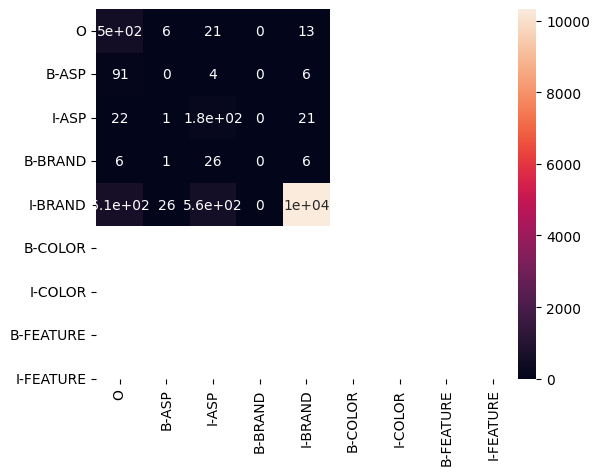

In [13]:
preds = trainer.predict(datasets['test'])
pred_labels = np.argmax(preds.predictions, axis=-1)
true_labels = preds.label_ids
y_true, y_pred = [], []
for pred, true in zip(pred_labels, true_labels):
    for p, t in zip(pred, true):
        if t != -100:
            y_true.append(id2label[t])
            y_pred.append(id2label[p])
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.show()



In [14]:
model.config.label2id = label2id
model.config.id2label = id2label

aspect_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

example = "HP laptops have great battery life and come in silver and black"
results = aspect_pipe(example)

for res in results:
    print(f"{res['entity_group']} → {res['word']} ({res['score']:.2f})")


Device set to use cuda:0
The model 'PeftModelForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DiffLlamaForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification', 'GlmForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassificati

ASP → HP (0.36)
ASP → laptops (0.46)
ASP → battery life (0.54)
ASP → silver (0.34)


In [15]:
aspect_pipe = pipeline(
    "token-classification", 
    model=model, 
    tokenizer=tokenizer, 
    aggregation_strategy="simple"
)


Device set to use cuda:0
The model 'PeftModelForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DiffLlamaForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification', 'GlmForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassificati

In [16]:
results = aspect_pipe("The battery is bright and the hand bag is good.")

for res in results:
    print(f"Entity: {res['word']}, Type: {res['entity_group']}, Score: {res['score']}")


Entity: battery, Type: ASP, Score: 0.6476438045501709
Entity: hand bag, Type: ASP, Score: 0.5744099617004395


In [17]:
sentiment_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}


In [18]:
sentiment_df = []
for df in [train_df, eval_df, test_df]:
    for i, row in df.iterrows():
        text = row["text"]
        for ann in eval(row["annotations"]):
            asp, _, sent, _ = ann
            if asp != "null":
                formatted = {
                    "text": f"Aspect: {asp}. Sentence: {text}",
                    "label": sentiment_map[sent]  # Use the sentiment_map for conversion
                }
                sentiment_df.append(formatted)

sentiment_df = pd.DataFrame(sentiment_df)
sentiment_dataset = Dataset.from_pandas(sentiment_df)


In [19]:
def tokenize_sentiment(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

sentiment_dataset = sentiment_dataset.map(tokenize_sentiment, batched=True)
sentiment_dataset = sentiment_dataset.train_test_split(test_size=0.1)
sentiment_dataset = sentiment_dataset.remove_columns([c for c in sentiment_dataset["train"].column_names if c not in ["input_ids", "attention_mask", "label"]])

sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)

sentiment_model = get_peft_model(sentiment_model, lora_config)
sentiment_model.print_trainable_parameters()

sentiment_args = TrainingArguments(
    output_dir="./deberta-sentiment-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=7,
    logging_dir="./logs",
    report_to="none"
)

sentiment_trainer = Trainer(
    model=sentiment_model,
    args=sentiment_args,
    train_dataset=sentiment_dataset["train"],
    eval_dataset=sentiment_dataset["test"],
    tokenizer=tokenizer
)

sentiment_trainer.train()

Map:   0%|          | 0/3130 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/1151180748.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  sentiment_trainer = Trainer(


trainable params: 297,219 || all params: 184,721,670 || trainable%: 0.1609


No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.765700
1000,0.450200
1500,0.375200
2000,0.363600


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2471, training_loss=0.4630803625769868, metrics={'train_runtime': 620.6679, 'train_samples_per_second': 31.771, 'train_steps_per_second': 3.981, 'total_flos': 1301607774125568.0, 'train_loss': 0.4630803625769868, 'epoch': 7.0})

In [20]:
eval_results = sentiment_trainer.evaluate(sentiment_dataset["test"])
print(eval_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.3584522008895874, 'eval_runtime': 4.7956, 'eval_samples_per_second': 65.268, 'eval_steps_per_second': 8.341, 'epoch': 7.0}


              precision    recall  f1-score   support

    negative       0.89      0.97      0.93       127
     neutral       0.50      0.04      0.08        23
    positive       0.89      0.94      0.92       163

    accuracy                           0.89       313
   macro avg       0.76      0.65      0.64       313
weighted avg       0.86      0.89      0.86       313



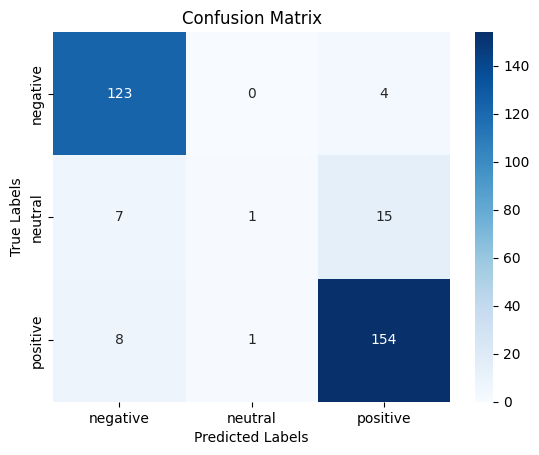

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure that you have defined 'id2label' and 'label2id' properly
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

# Evaluation
preds = sentiment_trainer.predict(sentiment_dataset["test"])
pred_labels = np.argmax(preds.predictions, axis=-1)
true_labels = preds.label_ids

# Prepare the lists for classification report
y_true, y_pred = [], []
for pred, true in zip(pred_labels, true_labels):
    if true != -100:  # Avoid padding label
        y_true.append(id2label[true])  # Append the true label
        y_pred.append(id2label[pred])  # Append the predicted label

# Print classification report
print(classification_report(y_true, y_pred))

# Confusion matrix and heatmap
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [22]:
# Final Inference Function
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
sentiment_pipe = pipeline(
    "text-classification",
    model=sentiment_model,
    tokenizer=tokenizer,
    return_all_scores=True
)
def infer_aspects_and_sentiments(text):
    aspects = aspect_pipe(text)
    output = {}
    for asp in aspects:
        asp_text = asp["word"]
        input_text = f"Aspect: {asp_text}. Sentence: {text}"
        result = sentiment_pipe(input_text)
        pred_sent = sorted(result[0], key=lambda x: x["score"], reverse=True)[0]
        sentiment_label = id2label[int(pred_sent["label"].split('_')[1])]  # Map to human-readable label
        output[asp_text] = sentiment_label
    return output




Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForTokenClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSequenceClassifi

In [23]:
# Example usage
example_text = "HP laptops have bad battery life and come in silver and black"
print(infer_aspects_and_sentiments(example_text))

{'laptops': 'negative', 'battery life': 'negative'}
